# 模型训练及预测

## 1. 导入库

In [11]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

## 2. 超参数配置

In [12]:
batch_size = 64       # 批处理大小，每次训练使用的样本数量
learning_rate = 0.01  # 学习率，控制每次参数更新的步长
momentum = 0.5        # 动量参数，帮助优化器在相关方向上加速并抑制震荡
EPOCH = 10            # 训练轮数，完整遍历训练集的次数

## 3. 导入数据集

### 3.1 归一化
- 0.1307 是 `mean` 均值
- 0.3081 是 `std` 标准差

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))])

### 3.2 载入数据集

In [14]:
train_dataset = datasets.MNIST(root='./datasets/mnist', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./datasets/mnist', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 4. 定义模型结构

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层(图是先卷积后激活再池化，差别不大)
        x = self.conv2(x)  # 再来一次
        # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

In [16]:
# 实例化模型
model = Net()

# 将模型移动到GPU（如果可用）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## 5. 损失函数和优化器
- 交叉熵损失
- 随机梯度下降

In [17]:
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量

## 6. 训练轮

In [18]:
def train(epoch):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        # 将数据移动到GPU
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零

## 7. 测试轮

In [19]:
def test(epoch):
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' %
          (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc

## 8. 开始训练

[1,   300]: loss: 0.828 , acc: 76.45 %
[1,   600]: loss: 0.234 , acc: 93.15 %
[1,   900]: loss: 0.164 , acc: 95.11 %
[1 / 10]: Accuracy on test set: 96.5 % 
[2,   300]: loss: 0.128 , acc: 96.14 %
[2,   600]: loss: 0.107 , acc: 96.74 %
[2,   900]: loss: 0.104 , acc: 96.97 %
[2 / 10]: Accuracy on test set: 97.4 % 
[3,   300]: loss: 0.085 , acc: 97.27 %
[3,   600]: loss: 0.087 , acc: 97.45 %
[3,   900]: loss: 0.082 , acc: 97.53 %
[3 / 10]: Accuracy on test set: 97.8 % 
[4,   300]: loss: 0.070 , acc: 97.74 %
[4,   600]: loss: 0.069 , acc: 97.80 %
[4,   900]: loss: 0.072 , acc: 97.77 %
[4 / 10]: Accuracy on test set: 98.2 % 
[5,   300]: loss: 0.065 , acc: 98.00 %
[5,   600]: loss: 0.064 , acc: 98.04 %
[5,   900]: loss: 0.057 , acc: 98.36 %
[5 / 10]: Accuracy on test set: 98.4 % 
[6,   300]: loss: 0.055 , acc: 98.33 %
[6,   600]: loss: 0.055 , acc: 98.26 %
[6,   900]: loss: 0.055 , acc: 98.29 %
[6 / 10]: Accuracy on test set: 98.5 % 
[7,   300]: loss: 0.049 , acc: 98.49 %
[7,   600]: loss: 0

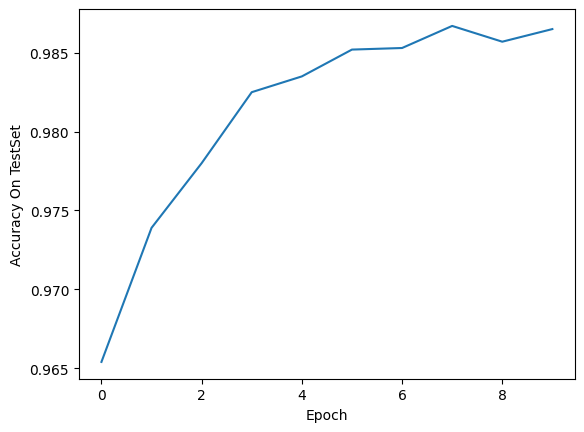

In [20]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train(epoch)
        acc_test = test(epoch)
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()

## 9. 模型推理(图片)

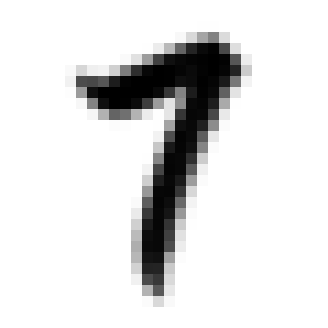

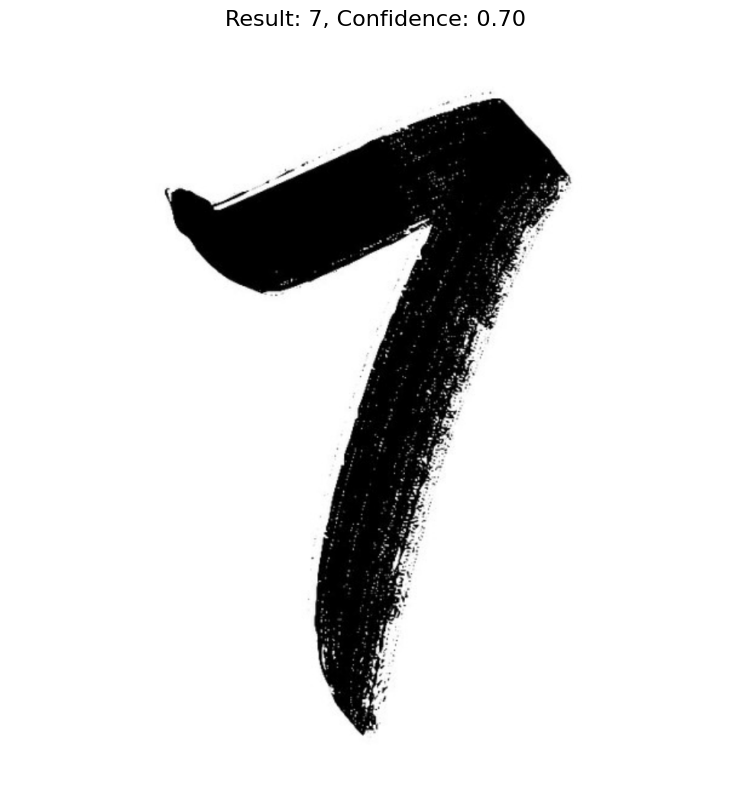

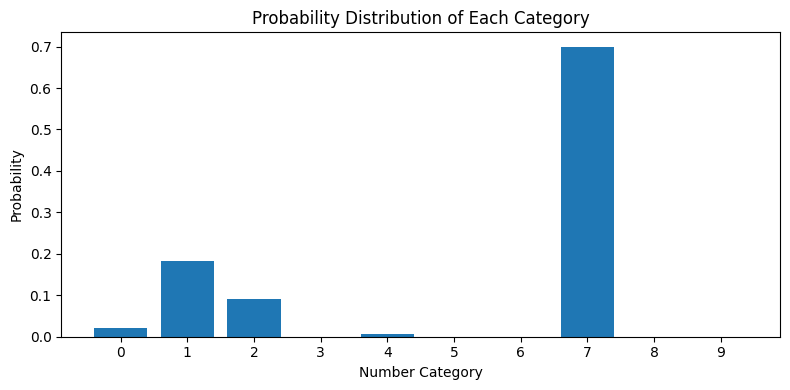

预测结果: 7, 置信度: 0.70


In [19]:
# 导入必要的库
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# 定义图像预处理
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 调整图像大小为模型输入尺寸
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST数据集的标准化参数
])

# 加载本地图片并进行预测
def predict_image(image_path):
    # 加载图片
    img = Image.open(image_path).convert('L')  # 转换为灰度图
    
    # 预处理图片
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # 显示预处理后的图像
    plt.figure(figsize=(4, 4))
    plt.imshow(img_tensor[0, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
        
    # 进行预测
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        prob = torch.nn.functional.softmax(output, dim=1)
    
    # 显示图片并在上方标注识别结果
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    plt.title(f"Result: {predicted.item()}, Confidence: {prob[0][predicted].item():.2f}", fontsize=16)
    plt.axis('off')  # 不显示坐标轴
    plt.tight_layout()
    plt.show()
    
    # 额外显示概率分布图
    plt.figure(figsize=(8, 4))
    plt.bar(range(10), prob[0].cpu().numpy())
    plt.xticks(range(10))
    plt.xlabel("Number Category")
    plt.ylabel("Probability")
    plt.title("Probability Distribution of Each Category")
    plt.tight_layout()
    plt.show()
    
    return predicted.item(), prob[0][predicted].item()

# 使用示例
# 请替换为您自己的图片路径
image_path = "./img/7.png"
predicted_digit, confidence = predict_image(image_path)
print(f"预测结果: {predicted_digit}, 置信度: {confidence:.2f}")


## 10. 模型推理(视频)

In [14]:
# 导入所需的库
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import time

# 定义实时视频识别函数
def real_time_recognition():
    # 打开摄像头
    cap = cv2.VideoCapture(1)
    
    if not cap.isOpened():
        print("无法打开摄像头")
        return
    
    print("摄像头已打开，按 'q' 键退出")
    
    while True:
        # 读取一帧
        ret, frame = cap.read()
        
        if not ret:
            print("无法获取画面")
            break
        
        # 处理帧
        # 转换为灰度图
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # 调整大小为模型输入尺寸
        resized = cv2.resize(gray, (28, 28))
        
        # 转换为PIL图像
        pil_img = Image.fromarray(resized)
        
        # 预处理图像
        img_tensor = transform(pil_img).unsqueeze(0).to(device)
        
        # 进行预测
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            prob = torch.nn.functional.softmax(output, dim=1)
        
        # 在原始帧上显示结果
        result_text = f"Prediction: {predicted.item()}, Confidence: {prob[0][predicted].item():.2f}"
        cv2.putText(frame, result_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # 显示帧
        cv2.imshow('Real-Time Digit Recognition', frame)
        
        # 按q键退出
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        # 控制帧率
        time.sleep(0.03)
    
    # 释放资源
    cap.release()
    cv2.destroyAllWindows()

# 运行实时识别
try:
    real_time_recognition()
except Exception as e:
    print(f"发生错误: {e}")
    # 确保资源被释放
    cv2.destroyAllWindows()


摄像头已打开，按 'q' 键退出
